# Musterlösung Übung 7: Projekt

Diese Musterlösung ist eine reale Abgabe, wurde mit voller Punktzahl bewertet und freundlicherweise 
von der einreichenden Person zur allgemeinen Begutachtung zur Verfügung gestellt.

## Library Import

Pandas, Numpy, typing, etwaige scikit-learn features und seaborn

In [2]:
from typing import Any, Optional

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import r2_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder

%matplotlib inline

## Einlesen des Datensatzes

Spalte **PublishDate** in `datetime` umwandeln und **IDLink** als Index setzen

In [3]:
df = pd.read_csv('data/news.csv', parse_dates=['PublishDate'])

# IDLink -> int, index setzen
df.IDLink = df.IDLink.astype(int)
df = df.set_index('IDLink')

## Untersuchen des Datensatzes

In [4]:
df.head()

,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
IDLink,,,,,,,,,,
99248,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
10423,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
18828,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
27788,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
27789,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


In [5]:
df.describe()

,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
count,93239.000000,93239.000000,93239.000000,93239.000000,93239.000000
mean,-0.005411,-0.027493,113.141336,3.888362,16.547957
std,0.136431,0.141964,620.173233,18.492648,154.459048
min,-0.950694,-0.755433,-1.000000,-1.000000,-1.000000
25%,-0.079057,-0.114574,0.000000,0.000000,0.000000
50%,0.000000,-0.026064,5.000000,0.000000,0.000000
75%,0.064255,0.059709,33.000000,2.000000,4.000000
max,0.962354,0.964646,49211.000000,1267.000000,20341.000000


Aus dem `describe()` ist ersichtlich, dass die Sentiment-Werte warscheinlich auf einen Bereich von 1 bis -1 beschränkt sind. Anhand der Perzentile ist ersichtlich, dass die meisten Titel / Headlines als neutral wahrgenommen werden.

In [6]:
df.sort_values('SentimentTitle')[['Title', 'SentimentTitle']].tail()

,Title,SentimentTitle
IDLink,,
68482,Obama administration upbeat about health law s...,0.795495
68377,Obama Administration Upbeat About Health Law S...,0.795495
68390,Obama administration upbeat about health law s...,0.795495
5433,Arkansas Economy Significantly Improving,0.925000
15033,We just got some really great news about the e...,0.962354


In [7]:
df.sort_values('SentimentTitle')[['Title', 'SentimentTitle']].head()

,Title,SentimentTitle
IDLink,,
53495,Satya Nadella just fixed a massive problem at ...,-0.950694
22793,Improving economy not helping all,-0.838525
39952,IMF Head: More Support Needed for &quot;Too Sl...,-0.833784
42857,"G20 worried by 'modest' global growth, commodi...",-0.793040
38763,Stressed Out: Tension a Silent Killer for Swed...,-0.791667


Es ist zu vermuten, dass ein größeres Sentiment eine positivere Nachricht bedeutet.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93239 entries, 99248 to 61870
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              93239 non-null  object        
 1   Headline           93224 non-null  object        
 2   Source             92960 non-null  object        
 3   Topic              93239 non-null  object        
 4   PublishDate        93239 non-null  datetime64[ns]
 5   SentimentTitle     93239 non-null  float64       
 6   SentimentHeadline  93239 non-null  float64       
 7   Facebook           93239 non-null  int64         
 8   GooglePlus         93239 non-null  int64         
 9   LinkedIn           93239 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.8+ MB


Die Datentypen ergeben Sinn.

## Mögliche Supervised Learning Tasks

### Task 1

Der erste mögliche Task wäre, aus dem **Title** das **Topic** vorherzusagen. Dabei dienen die unveränderten Topic-Strings als Labels (sklearn hat kein Problem damit Strings als Labels zu verwenden). Als Feature Matrix würde eine N-Grams Bag-of-Words Repräsentation der **Title**-Spalte verwendet werden. Dies ist ein Klassifikationsproblem.
 
### Task 2

Ein zweiter möglicher Task wäre, **SentimentTitle** in Klassen aufzuteilen und dann diese Klassen wieder anhand der **Title**-Spalte vorherzusasgen. Ähnlich wie bei _Task 1_ handelt es sich hierbei um ein Klassifikationsproblem. Die Feature Matrix wäre auch hier wieder eine N-Grams Bag-of-Words Repräsentation der **Title**-Spalte. Die Labels wären Integer, die die Klassen darstellen, in die die kontinuierlichen **SentimentTitle**-Werte aufgeteilt wurden.

### Task 3

Als dritter möglicher Task bietet es sich an, das Regressionspendant des _Task 2_ zu bearbeiten. Dabei könnte man anstelle des **Title** die **Headline** untersuchen. Die Feature Matrix wäre also eine N-Grams Bag-of-Words Repräsentation der **Headline**-Spalte. Der y-Vektor besteht aus den bestehenden Gleitkommazahlen der **SentimentHeadline**-Spalte. Die **SentimentHeadline**-Werte liegen zwar schon zentriert zwischen -1 und 1, aber Normalisierung durch Z-Scoring könnte trotzdem vorteilhaft sein.

### Auswahl

Im folgenden werden die beiden Klassifikationsprobleme, also _Task 1_ sowie _Task 2_ implementiert.

## Statistiken

### 1. Fehlende Werte

Vor dem Verwenden eines Datensatzes ist es hilfreich, diesen auf fehlende (null) Werte zu untersuchen. ML-Algorithmen können normalerweise nicht mit fehlenden Werten arbeiten, weshalb diese entfernt werden müssen. Wie hier im Diagramm zu sehen, gibt es fehlende Werte in der **Headline**- und in der **Source**-Spalte. Diese Spalten werden in den hier implementierten Tasks nicht verwendet, es sind also keine weiteren Maßnahmen in dieser Hinsicht erforderlich.

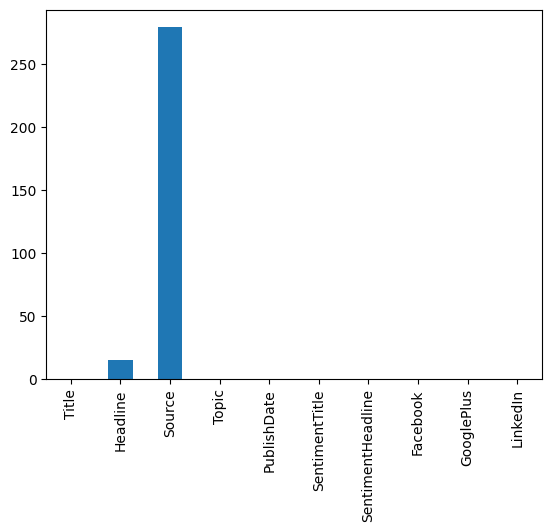

In [9]:
df.isnull().sum().plot.bar();

### 2. Sentimentverteilung

Für das Aufteilen der **SentimentTitle**-Spalte in Klassen ist es hilfreich zu wissen, wie die Daten innerhalb des Wertebereichs verteilt sind. Es ist zu erkennen, dass es sinnvoller ist, den Datensatz in Klassen mit gleicher Anzahl an Elementen zu zerlegen als den Wertebereich in gleichgroße Stücke einzuteilen. Die meisten Artikel werden eher als neutral wahrgenommen.

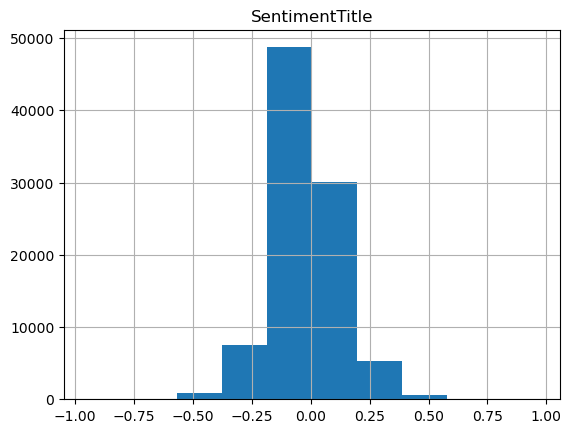

In [54]:
df.hist(column='SentimentTitle');

### 3. Titellänge

Um einen Wertebereich für die Hyperparameteroptimierung für die Größe der N-Grams festlegen zu können, ist es hilfreich zu wissen wie viele Wörter die Titel enthalten. Wie zu sehen, befindet sich die Mitte des Histograms bei ungefähr 8-9 Wörter, die Größe der N-Grams sollte diesen Wert auf jeden Fall nicht überschreiten.

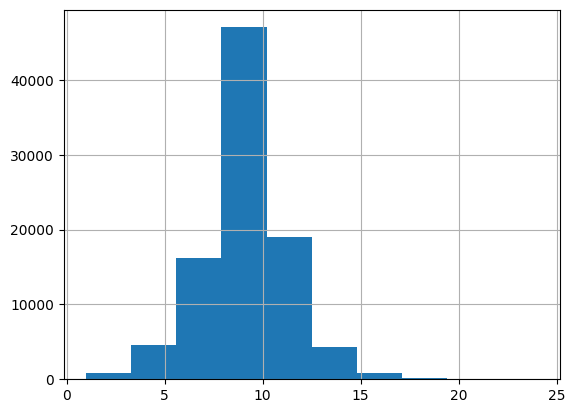

In [10]:
df['Title'].apply(lambda data: len(str(data).split(' '))).hist();

### 4. Topicverteilung

Es sollte jede Klasse häufig genug vertreten sein, um ein Modell gut trainieren zu können. Unterrepräsentierte Klassen werden möglicherweise überhaupt nicht vorhergesagt.

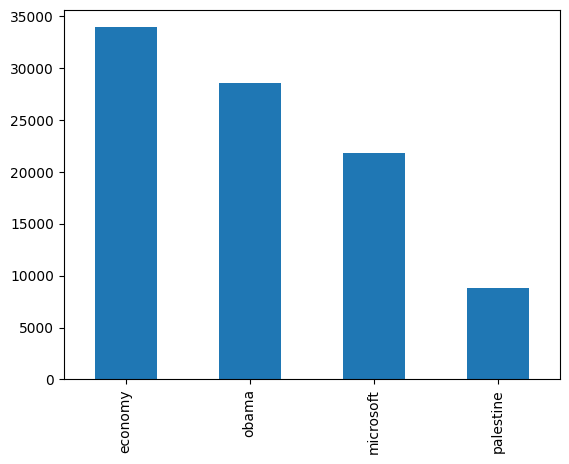

In [12]:
df['Topic'].value_counts().plot.bar();

## Implementierung

### Hilfsfunktionen

Die erste Funktion generiert alle möglichen korrekten Parametermöglichkeiten für die Größe von N-Grams zwischen einem Minimum und einem Maximum für die Hyperparameteroptimierung. Für ein Minimum von 1 und einem Maximum von 2 sieht das Resultat wie folgt aus: `[(1, 1), (1, 2), (2, 2)]`.

Die zweite Funktion evaluiert ein ML-Modell für Klassifizierungsprobleme an einen gegebenen Datensatz und generiert einen classification_report sowie eine Confusion-Matrix. Der Code zum Erstellen der Matrix ist teilweise aus den Übungsaufgaben kopiert.

In [57]:
def generate_ngram_range_parameters(min_ngrams: int, max_ngrams: int) -> list[tuple[int, int]]:
    return [(min, max) for max in range(min_ngrams, max_ngrams+1) for min in range(min_ngrams, max+1)]

def evaluate_classification_model(model, X, y, alternative_labels: Optional[dict[Any, str]] = None) -> None:
    labels = np.sort(y.unique())

    if alternative_labels:
        str_labels: list[str] = [alternative_labels[label] for label in labels]
    else:
        str_labels: list[str] = list(map(str, list(labels)))

    predicted = model.predict(X)
    matrix = confusion_matrix(y, predicted, labels=labels)

    print(classification_report(y, predicted))

    ax = sns.heatmap(matrix, annot=True, cmap='Blues', cbar=False, fmt='g', 
                     xticklabels=str_labels, yticklabels=str_labels)
    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values');

### Task 1

Hier kommt ein K-Nearest Neighbor Classifier zum Einsatz. Diese Art von Modell wird trainiert, indem alle Trainingsdaten gespeichert werden. Soll nun ein neuer Datenpunkt einer Klasse zugeordnet werden, so wird die Distanz vom neuen Punkt zu allen bestehenden Punkten ausgerechnet. Dann werden die K nächsten Punkte ausgewählt und das meistvertretene Label als Ergebnis gewählt. Als Distanzfunktion wird meist der Euklidische Abstand verwendet, aber auch andere Methoden sind denkbar.

Zusätzlich zur N-Grams Größe wird nun die Anzahl an zu evaluierenden Nachbarn "K" per Hyperparameteroptimierung ausgewählt. Dabei kommt Random Search zum Einsatz.

Potentielle Verbesserungen des Ergebnis wären eventuell durch einen größeren Suchbereich für die Hyperparameter und eine größere Anzahl an Iterationen der Random Search zu erziehlen, da so möglicherweise bessere Parameter gefunden werden könnten. Auch eine bessere Stop-Words-Liste könnte helfen, da die in scikit-learn eingebaute Liste viele vorraussichtlich relevante Wörter filtert.

/usr/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

     economy       0.94      0.96      0.95     10179
   microsoft       1.00      0.96      0.98      6557
       obama       0.99      0.96      0.98      8583
   palestine       0.81      0.88      0.85      2653

    accuracy                           0.95     27972
   macro avg       0.93      0.94      0.94     27972
weighted avg       0.96      0.95      0.95     27972



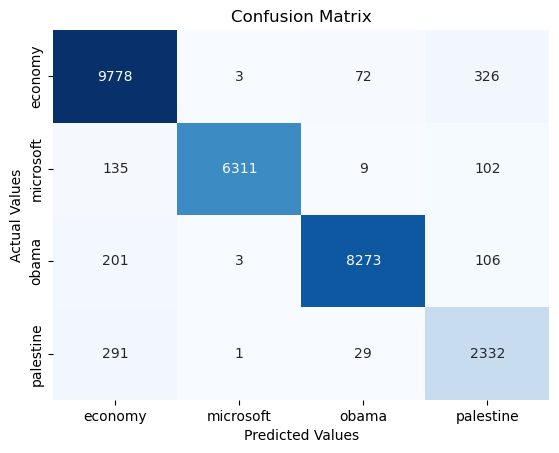

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['Title'], df['Topic'], test_size=0.3, stratify=df['Topic'])

pipe = Pipeline([('vect', CountVectorizer(stop_words='english')), ('knc', KNeighborsClassifier(n_jobs=4))])

param_grid = {'vect__ngram_range': generate_ngram_range_parameters(1, 2),
              'knc__n_neighbors': range(1,5)}
              
model = RandomizedSearchCV(pipe, param_grid, scoring="accuracy", n_jobs=4, n_iter = 5).fit(X_train, y_train)

evaluate_classification_model(model, X_test, y_test)

### Task 2

Für diesen Task wurde ein Perceptron verwendet. Ein Perceptron ist einem Neuron nachempfunden und hat in seiner einfachsten Form einen Eingangsvektor und eine einzelne Schicht an Neuronen als Ausgang. Jedes Neuron ist mit jedem Eingang verbunden, wobei jede dieser Verbindungen mit einem Gewicht assoziiert ist. Zur Berechnung des Ausgangs eines Neurons muss jeder Eingang mit dem zugehörigen Gewicht multipliziert und dann aufsummiert werden, wonach das Ergebnis mit der Fehlerfunktion des Neurons verrechnet wird. Der Perceptron lernt, indem per Gradient Descent die Gewichte so angepasst werden, dass eine Fehlerfunktion minimal wird.

Es wird nur die N-Grams Größe als Hyperparameter per Grid Search optimiert. Die **SentimentTitle**-Spalte wird in 3 Bins mit gleicher Anzahl Datenpunkten mit Hilfe eines KBinsDiscretizers zerlegt.

Das Ergebnis könnte verbessert werden, indem man einen Multilayer Perceptron anstelle eines normalen Perceptrons verwendet. Der Multilayer Perceptron kann auch nicht linear separierbare Probleme lösen. Eine weitere Verbesserung wäre potentiell durch das Optimieren von mehr Hyperparametern des Perceptrons zu erreichen. Parameter die besser zum vorliegenden Problem passen verbessern vorraussichtlich das Ergebnis.

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9256
           1       0.72      0.65      0.68      9314
           2       0.78      0.82      0.80      9402

    accuracy                           0.76     27972
   macro avg       0.76      0.76      0.76     27972
weighted avg       0.76      0.76      0.76     27972



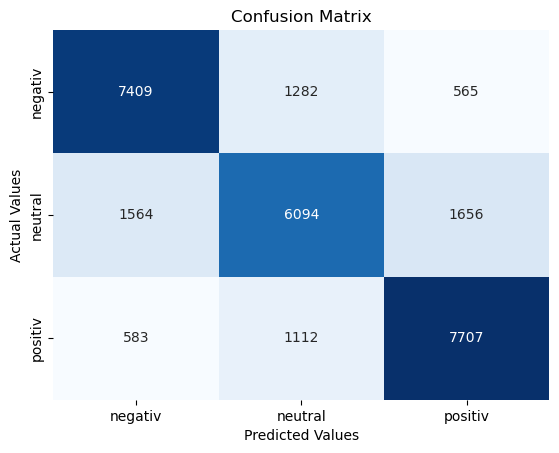

In [59]:
# Transformieren des Titel-Sentiments in 3 Klassen mit gleicher Anzahl an Elementen
sentiment_title_shaped_array = df['SentimentTitle'].values.reshape(-1, 1)
df['SentimentTitleBinned'] = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile').fit_transform(sentiment_title_shaped_array).astype(int)

X_train, X_test, y_train, y_test = train_test_split(df['Title'], df['SentimentTitleBinned'], test_size=0.3, stratify=df['SentimentTitleBinned'])

pipe = Pipeline([('vect', CountVectorizer()), ('perc', Perceptron(n_jobs=5, max_iter=200000, early_stopping=True))])

param_grid = {'vect__ngram_range': generate_ngram_range_parameters(1, 4)}
              
model = GridSearchCV(pipe, param_grid, scoring="accuracy", n_jobs=4).fit(X_train, y_train)

evaluate_classification_model(model, X_test, y_test, {0: 'negativ', 1: 'neutral', 2: 'positiv'})